# Ordinary Linear Regression VS Bayesian Linear Regression

The Economic Freedom Index is poised to help readers track over two decades of the advancement in economic freedom, prosperity, and opportunity and promote these ideas in their homes, schools, and communities. The Index covers 12 freedoms – from property rights to financial freedom – in 186 countries. The measurement of economic freedom is based on 12 quantitative and qualitative factors, grouped into four broad categories, or pillars, of economic freedom:

- Rule of Law (property rights, government integrity, judicial effectiveness)
- Government Size (government spending, tax burden, fiscal health)
- Regulatory Efficiency (business freedom, labor freedom, monetary freedom)
- Open Markets (trade freedom, investment freedom, financial freedom)

In [1]:
#hide
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Let's see if business freedom has the same impact on GDP for countries in North America and Europe and outside.

In [227]:
data = pd.read_csv("/Users/jonny/Downloads/economic_freedom_index2019_data.csv", 
                   encoding='ISO-8859-1')[["Region", "Business Freedom", "GDP per Capita (PPP)"]]

# drop null rows
data = data.dropna(axis = 0, how = "any")
data.head()

,Region,Business Freedom,GDP per Capita (PPP)
0,Asia-Pacific,49.2,"$1,958"
1,Europe,69.3,"$12,507"
2,Middle East and North Africa,61.6,"$15,237"
3,Sub-Saharan Africa,55.7,"$6,753"
4,Americas,56.4,"$20,876"


In [228]:
# GDP is a string, chnage it to int:
data["gdppc"] = list(map(lambda x: int(x.strip('$').replace(',', "").split(' ')[0]), data["GDP per Capita (PPP)"]))
data["log_gdppc"] = np.log(data["gdppc"])

# add 2 new features:
data["is_europe"] = data.Region == "Europe"
data["is_europe"] = data.is_europe.astype(int)
data["business_freedom_x_region"] = data.is_europe * data["Business Freedom"]

# subset and rename the columns that we need
df = data[["is_europe", "Business Freedom", "business_freedom_x_region", "log_gdppc"]].copy()
df.columns = ["is_europe", "business_freedom", "business_freedom_x_region", "log_gdppc"]
df.head()

,is_europe,business_freedom,business_freedom_x_region,log_gdppc
0,0,49.2,0.0,7.579679
1,1,69.3,69.3,9.434044
2,0,61.6,0.0,9.631482
3,0,55.7,0.0,8.817742
4,0,56.4,0.0,9.946355


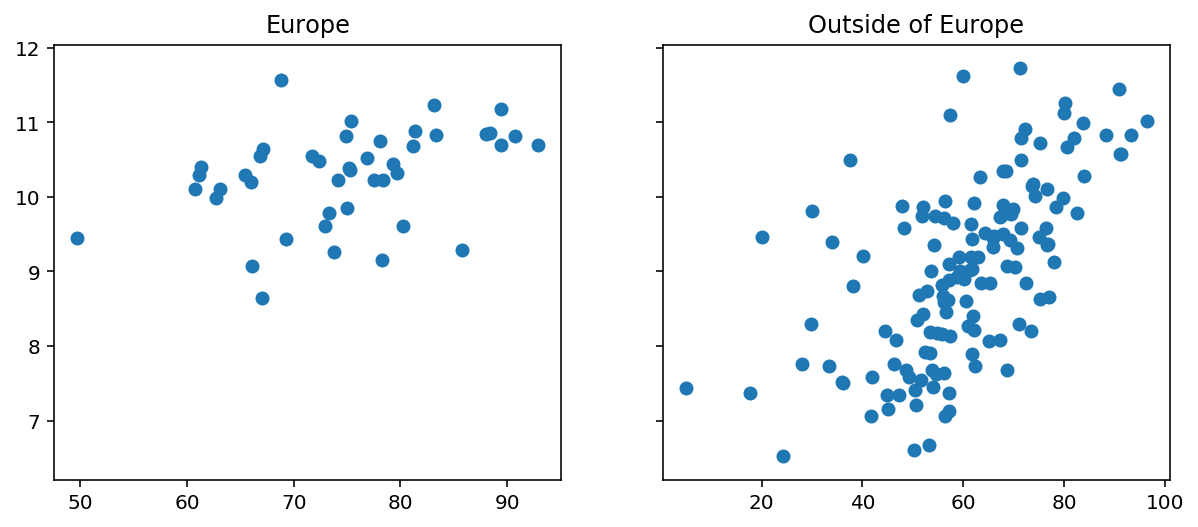

In [303]:
inside_europe = df[df.is_europe == 1]
outside_europe = df[df.is_europe == 0]

x = "business_freedom"
y = "log_gdppc"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)
ax[0].scatter(x = inside_europe[x], y = inside_europe[y])
ax[0].set(title = "Europe")
ax[1].scatter(x = outside_europe[x], y = outside_europe[y])
ax[1].set(title = "Outside of Europe");

## Ordinary Linear Regression

In [230]:
features = ["business_freedom", "business_freedom_x_region", "is_europe"]
x = df[features]
y = df["log_gdppc"]

reg = LinearRegression()
_ = reg.fit(x, y)

coef = dict([i for i in zip(list(x.columns), reg.coef_)]); coef
print("Intercept: %f" % reg.intercept_)
print("Coefficient of Determination: %f" % reg.score(x, y))

{'business_freedom': 0.046021183174684115,
 'business_freedom_x_region': -0.02015001509198234,
 'is_europe': 2.0992420204524835}

Intercept: 6.247260
Coefficient of Determination: 0.478465


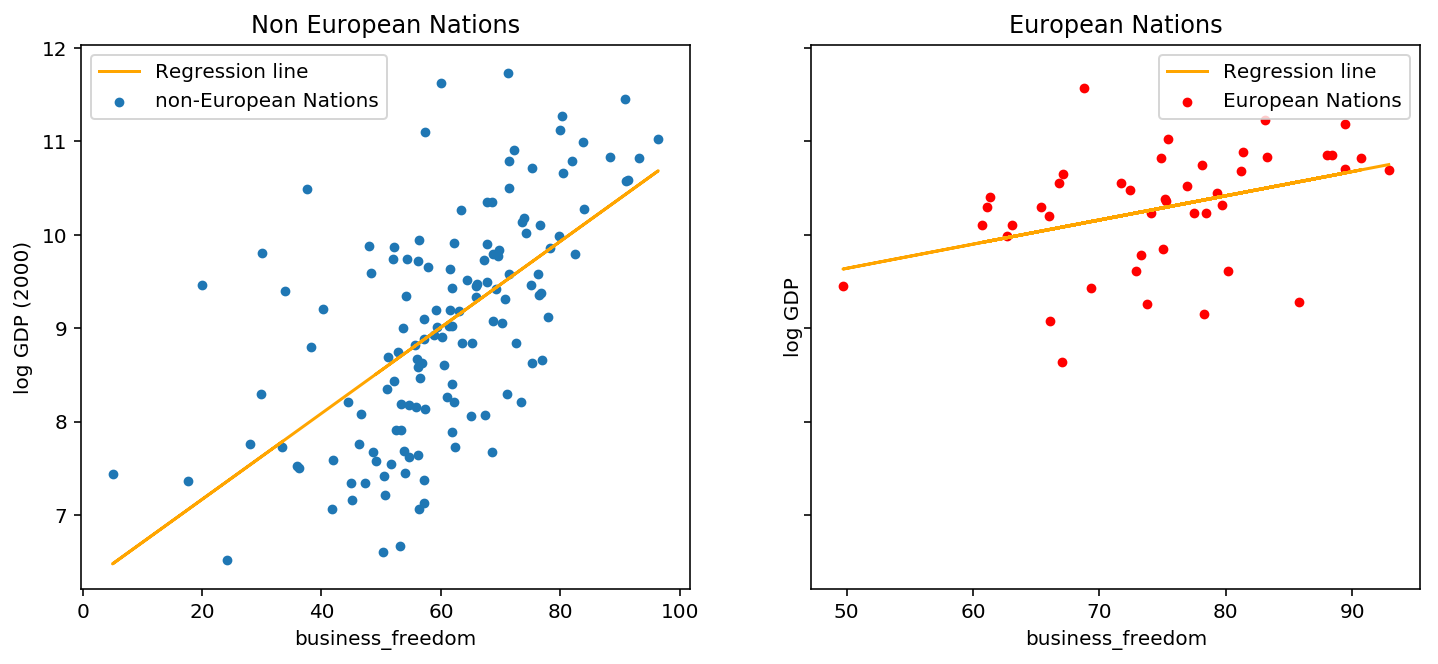

In [304]:
# predict log GPD using region and business freedom
europe_gdp = reg.predict(inside_europe[features])
non_europe_gdp = reg.predict(outside_europe[features])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)

ax[0].plot(outside_europe["business_freedom"],
           non_europe_gdp,
           color = "orange",
           label = "Regression line")
ax[0].scatter(outside_europe["business_freedom"],
              outside_europe["log_gdppc"],
              label="non-European Nations",
              s = 15)
ax[0].set(xlabel="business_freedom",
          ylabel="log GDP Per Capita",
          title="Non European Nations")

ax[1].plot(inside_europe["business_freedom"],
           europe_gdp,
           color = "orange",
           label = "Regression line")
ax[1].scatter(inside_europe["business_freedom"],
              inside_europe["log_gdppc"],
              color = "red",
              label="European Nations",
              s = 15)
ax[1].set(xlabel="business_freedom",
          ylabel="log GDP Per Capita",
          title="European Nations")
ax[0].legend()
ax[1].legend();

In [305]:
# backout the slopes of the regression lines for nations in and out of Europe
print("Slope for European Nations: ", 
      round(coef["business_freedom"] + coef["business_freedom_x_region"], 3))
print("Slope for non-European Nations: ", round(coef["business_freedom"], 3))

Slope for European Nations:  0.026
Slope for non-European Nations:  0.046


## Bayesian Regression

In [247]:
#hide
from functools import partial
import torch

import pyro
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule

from pyro.nn import PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

In [252]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        # PyroSample used to declare priors:
        self.linear.weight = PyroSample(dist.Normal(0., 5.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 5.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        # sample from the posterior
        obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [253]:
tensor_data = torch.tensor(df.values, dtype=torch.float)
x_data = tensor_data[:, [0, 1, 2]]
y_data = tensor_data[:, 3] 

In [254]:
model = BayesianRegression(3, 1)
auto_guide = AutoDiagonalNormal(model)

svi = SVI(model = model, # bayesian regression class  
          guide = auto_guide, # using auto guide
          optim = pyro.optim.Adam({"lr": 0.05}),
          loss=Trace_ELBO())

In [255]:
num_iterations = 2500

# param_store is where pyro stores param estimates
pyro.clear_param_store()

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 250 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 67.0926
[iteration 0251] loss: 2.7928
[iteration 0501] loss: 2.4033
[iteration 0751] loss: 1.8199
[iteration 1001] loss: 1.5908
[iteration 1251] loss: 1.4756
[iteration 1501] loss: 1.4575
[iteration 1751] loss: 1.5769
[iteration 2001] loss: 1.4664
[iteration 2251] loss: 1.5560


In [256]:
auto_guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal()

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2944,  1.5998,  0.0407, -0.0170,  6.2517])
AutoDiagonalNormal.scale tensor([0.0579, 0.1402, 0.0012, 0.0022, 0.0457])


In [257]:
num_samples = 1000
predictive = Predictive(model = model, 
                        guide = auto_guide, 
                        num_samples = num_samples,
                        return_sites=("linear.weight", "linear.bias", "obs", "_RETURN"))
pred = predictive(x_data)
weight = pred["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
bias = pred["linear.bias"]

In [258]:
#random
# columns of x_data: is_europe, business_freedom, business_freedom_x_region
print("Mean for posterior distributions: ", torch.mean(weight, 0))
print("97.5 percentile: ", weight.kthvalue(int(num_samples * 0.975), dim = 0)[0]) # find the 97.5 percentile value
print("2.5 percentile: ", weight.kthvalue(int(num_samples * 0.025), dim = 0)[0]) # find the 2.5 percentile value

columns = ["is_europe", "business_freedom", "business_freedom_x_region"]
bayes_coef = dict(zip(columns, torch.mean(weight, 0).numpy()))

Mean for posterior distributions:  tensor([ 1.6074,  0.0407, -0.0169])
97.5 percentile:  tensor([ 1.8948,  0.0431, -0.0128])
2.5 percentile:  tensor([ 1.3426,  0.0385, -0.0213])


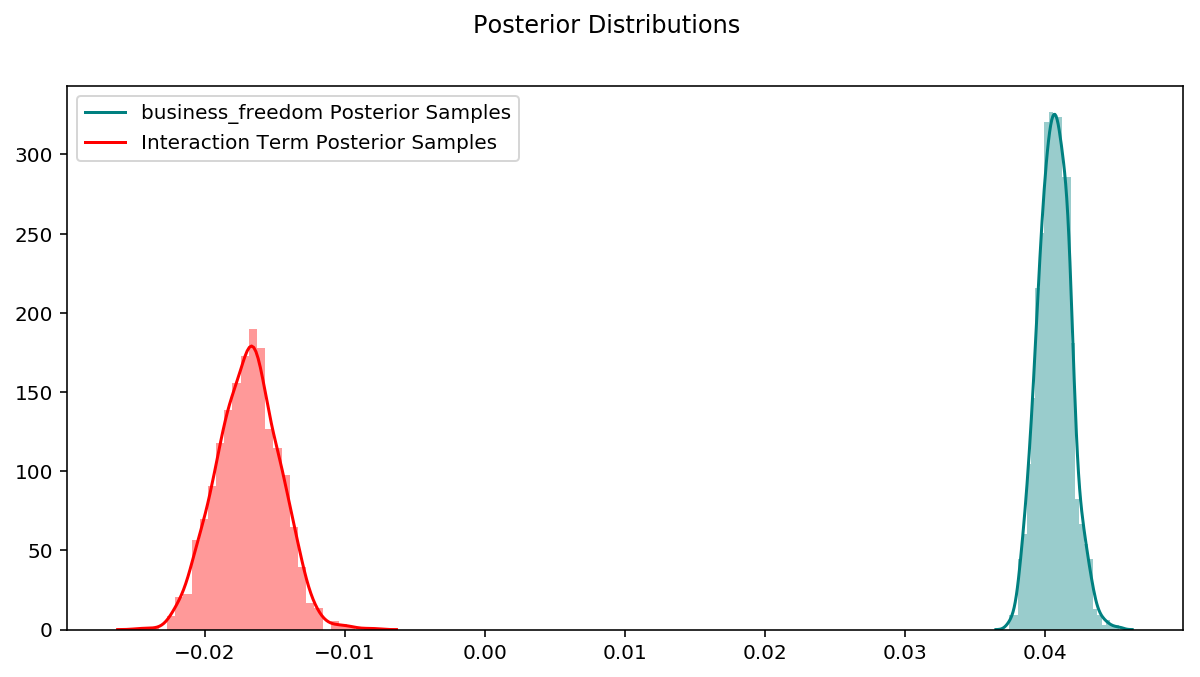

In [301]:
fig = plt.figure(figsize = (10, 5))
sns.distplot(weight[:, 1], 
             kde_kws = {"label": "business_freedom Posterior Samples"}, 
             color = "teal",
             norm_hist = True,
             kde = True)
sns.distplot(weight[:, 2], 
             kde_kws = {"label": "Interaction Term Posterior Samples"}, 
             color = "red",
             norm_hist = True,
             kde = True)

fig.suptitle("Posterior Distributions");

Slope for European nations:  0.023792317
Slope for non-European nations:  0.040710554


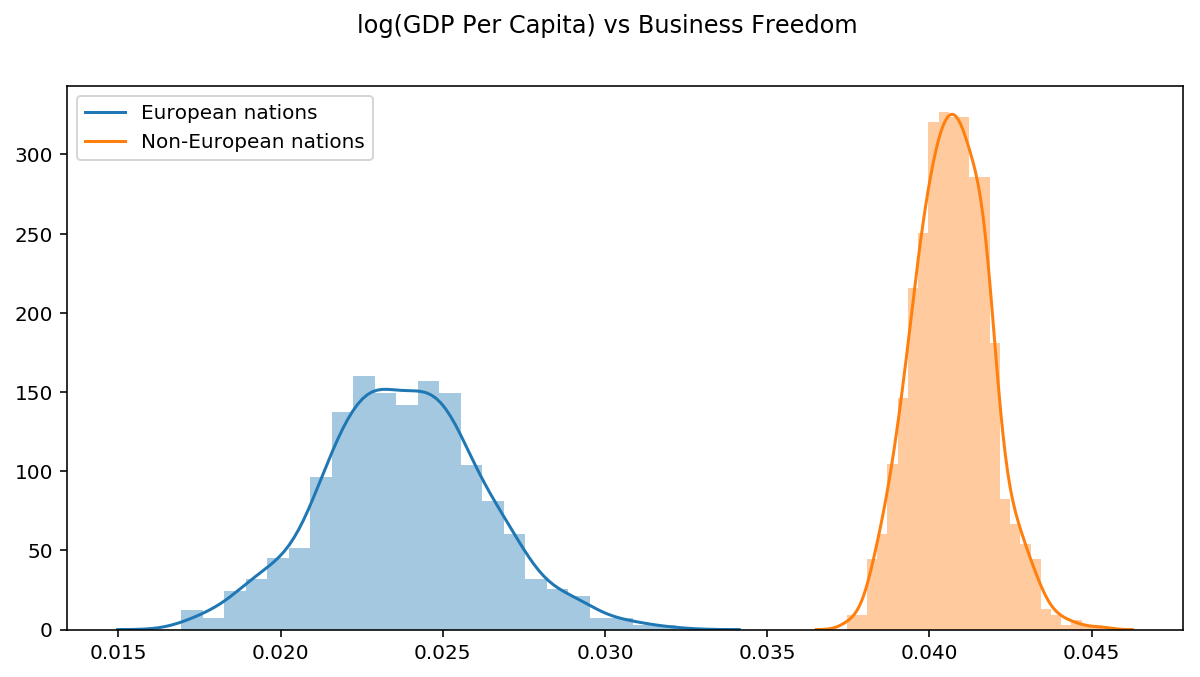

In [319]:
slope_inside_europe = weight[:, 1] + weight[:, 2] # business_freedom + business_freedom_x_region
slope_outside_europe = weight[:, 1] # business_freedom

print("Slope for European nations: ", torch.mean(slope_inside_europe).numpy()) # business_freedom + interaction
print("Slope for non-European nations: ", torch.mean(slope_outside_europe).numpy()) # business_freedom

fig = plt.figure(figsize=(10, 5))
sns.distplot(slope_inside_europe, kde_kws = {"label": "European nations"})
sns.distplot(slope_outside_europe, kde_kws={"label": "Non-European nations"})
fig.suptitle("log(GDP Per Capita) vs Business Freedom");

### Not Included in Blog

In [ ]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.025), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.975), dim=0)[0],
        }
    return site_stats

samples = predictive(x_data)
pred_summary = summary(samples)

mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})
predictions.head()

In [ ]:
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
fig.suptitle("Regression line with 95% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");